In [20]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

training_path = "fruits-360_dataset/Training"
test_path = "fruits-360_dataset/Test"

try:
    STATS = np.load("stats.npy", allow_pickle=True)
except FileNotFoundError as fnf:
    print("Not found stats file.")
    STATS = []

# Parameters    
GRAY_SCALE = False
FRUITS = os.listdir(training_path)

random.shuffle(FRUITS)
FRUITS_DROP = 0.85  # dont load all fruits


Not found stats file.


In [21]:
def load_data(directory_path, load_all=False):
    data = []
    labels = []
               
            
    for fruit_name in FRUITS:
        class_num = FRUITS.index(fruit_name)                
        
        path = os.path.join(directory_path, fruit_name)
#         print(f"Adding: {class_num:>3} {fruit_name:<20}, {path}")
        
        for img in os.listdir(path):
            if not load_all and np.random.random() < FRUITS_DROP:  # skip image
                continue
                
            img_path = os.path.join(path, img)    
            if GRAY_SCALE:
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(img_path)
#                 image = image[:::]
                
#             image = image / 255.0
#             image = tf.keras.utils.normalize(image)
    
            data.append([image, class_num])

#         print(FRUITS[class_num])
        plt.figure()    
        plt.imshow(image, cmap='gray')
        plt.show()
        break
        
    random.shuffle(data)
        
    X = []
    y = []
    
    
    for image, label in data:
        X.append(image)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    if GRAY_SCALE:
        print("Reshaping gray scale")
        X = X.reshape(-1, X.shape[1], X.shape[2], 1)
        
    return X, y      

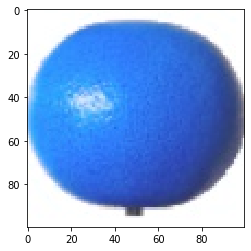


Created training array
X shape: (76, 100, 100, 3)
y shape: (76,)


In [22]:
X_training, y_training = load_data(training_path)
print("\nCreated training array")    
print(f"X shape: {X_training.shape}")
print(f"y shape: {y_training.shape}")

In [4]:
# Limit gpu memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.compat.v1.Session(config=config)

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Activation, Dropout

pic_shape = X_training.shape[1:]
label_count = len(FRUITS)

print(f"Pic shape: {pic_shape}")

# Input
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=pic_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
#     Dropout(0.15),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.15),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(label_count, activation='softmax')    
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Pic shape: (100, 100, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (N

In [6]:
training_history = model.fit(X_training, y_training, batch_size=25, epochs=5)

Train on 9043 samples
Epoch 1/5
9043/9043 [==============================] - 6s 695us/sample - loss: 3.1446 - accuracy: 0.2477
Epoch 2/5
9043/9043 [==============================] - 5s 541us/sample - loss: 1.0866 - accuracy: 0.6806
Epoch 3/5
9043/9043 [==============================] - 5s 547us/sample - loss: 0.5640 - accuracy: 0.8329
Epoch 4/5
9043/9043 [==============================] - 5s 550us/sample - loss: 0.3466 - accuracy: 0.8947
Epoch 5/5
9043/9043 [==============================] - 5s 552us/sample - loss: 0.2325 - accuracy: 0.9299


In [7]:
X_training = None
y_training = None

In [8]:
X_test, y_test = load_data(test_path, load_all=True)

print("\nCreated test array")    
print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

Reshaping gray scale

Created test array
X shape: (20622, 100, 100, 1)
y shape: (20622,)


In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

print(f"Test Accuracy: {accuracy:>2.4f}")
print(f"Test loss: {loss:>2.4f}")

count_incorrect = 0
for x, predict in enumerate(predictions):
    class_num = np.argmax(predict)
    valid = y_test[x] == class_num
    if not valid:
        count_incorrect += 1
print(f"Incorrect predictions: {count_incorrect}")       
predictions = None

20622/20622 [==============================] - 5s 229us/sample - loss: 1.3547 - accuracy: 0.7169
Test Accuracy: 0.7169
Test loss: 1.3547
Incorrect predictions: 5839


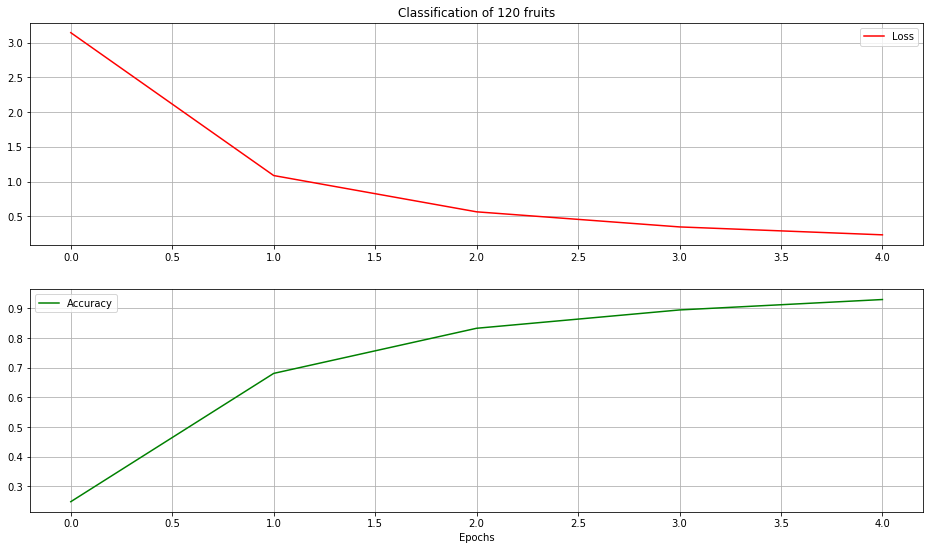

In [10]:
# from scipy.interpolate import CubicSpline

SMOOTH = False

epochs = training_history.epoch
loss = training_history.history['loss']
acc = training_history.history['accuracy']

if SMOOTH:    
    cs_loss = CubicSpline(epochs, loss)
    cs_acc = CubicSpline(epochs, acc)
    
    x = np.linspace(0, epochs[-1], 100)
    y_loss = cs_loss(x)
    y_acc = cs_acc(x)

else:
    x = epochs
    y_loss = loss
    y_acc = acc
    
plt.figure(figsize=(16,9))

ax1 = plt.subplot(2,1,1)
plt.title(f"Classification of {len(FRUITS)} fruits")
plt.plot(y_loss, label='Loss', c='r')
plt.legend(loc='best')
plt.grid()

plt.subplot(2,1,2)
plt.plot(y_acc, label='Accuracy', c='g')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.grid()

pic_name = ax1.get_title().replace(' ', '-')
plt.savefig(f"{pic_name}.png")

plt.show()

In [11]:
X_test = None
y_test = None
